In [1]:
import pandas as pd
from darts import TimeSeries
import numpy as np
from sktime.transformations.series.impute import Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    """
    Function to fix and standardize datetime in the given DataFrame.
    
    Parameters:
    - X: DataFrame to be modified.
    - name: String representing the name of the DataFrame, used for logging.
    
    Returns:
    - Modified DataFrame with standardized datetime.
    """

    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')

    # Sort DataFrame by the new datetime column ('ds') and set it as the index
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Log the shape of the DataFrame before dropping rows with in-between minutes
    print(f"Shape of {name} before dropping in-between hour rows: ", X.shape)

    # Identify and log gaps in the date sequence
    print(f"HEIHEI: {name} gaps in dates: ", X.index.to_series().diff().dt.total_seconds().gt(60*15).sum())
    print(f"HEIHEI: {name} first gap in dates: ", X[X.index.to_series().diff().dt.total_seconds().gt(60*15)==True].index[:1])

    # Calculate and log the size of each gap in the date sequence
    temp = X.index.to_series().diff().dt.total_seconds()
    if temp.shape[0] > 0:
        print(f"HEIHEI: {name} list of size (in days) of each gap: ", temp[temp.gt(60*15)].values / (60*60*24))
    
    # temporarily transform into darts time series to fill missing dates
    # get date_calc if date_calc is column in X
    temp_calc = None
    if "date_calc" in X.columns:
        temp_calc = X["date_calc"]
        X.drop(columns=['date_calc'], inplace=True)
    X = TimeSeries.from_dataframe(df=X, freq="15T", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    if temp_calc is not None:
        X["date_calc"] = temp_calc

    print(f"HEIHEI: {name} gaps in dates after filling missing dates: ", X.index.to_series().diff().dt.total_seconds().gt(60*15).sum())


    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0]

    # Log the shape of the DataFrame after dropping rows with in-between minutes
    print(f"Shape of {name} after dropping in-between hour rows: ", X.shape)

    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")


    X_train_observed["estimated_diff_hours"] = 0
    X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600.0
    X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600.0

    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}


def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)


    # # cast all columns to float64
    # X_train = X_train.astype('float64')
    # X_test = X_test.astype('float64')


    print(f"X_train_observed shape: {X_train_observed.shape}")
    print(f"X_train_estimated shape: {X_train_estimated.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")



    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    print("y_train columns: ", y_train.columns)

    # temporarily transform into darts time series to fill missing dates
    print("Shape of y_train before filling missing dates: ", y_train.shape)
    y_train = TimeSeries.from_dataframe(df=y_train, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    print("Shape of y_train after filling missing dates: ", y_train.shape)


    # number of gaps in X_train_observed + X_train_estimated before
    print(f"LOOK: Number of gaps in X_train_observed plus number of gaps in X_train_estimated before: ", X_train_observed.index.to_series().diff().dt.total_seconds().gt(3600).sum() + X_train_estimated.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    X_train = pd.concat([X_train_observed, X_train_estimated])
    print(f"LOOK: Number of gaps in X_train_observed plus number of gaps in X_train_estimated after: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    # print size of gaps in X_train
    temp = X_train.index.to_series().diff().dt.total_seconds()
    if temp.shape[0] > 0:
        print("LOOK: list of size (in days) of each gap: ", temp[temp.gt(3600)].values / (60*60*24))
    print("if the number is bigger after than before that means there is a gap in time between the observed and estimated training sets")

    # print info on dates in X_train, and if there are any missing dates
    print("X_train dates info: ", X_train.index.min(), X_train.index.max(), X_train.index.max() - X_train.index.min())
    print("X_test dates info: ", X_test.index.min(), X_test.index.max(), X_test.index.max() - X_test.index.min())
    print("y_train dates info: ", y_train.index.min(), y_train.index.max(), y_train.index.max() - y_train.index.min())

    # any gaps in dates?
    print("X_train gaps in dates: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("X_test gaps in dates: ", X_test.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("y_train gaps in dates: ", y_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())

    # temporarily transform into darts time series to fill missing dates
    X_train = TimeSeries.from_dataframe(df=X_train, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    X_test = TimeSeries.from_dataframe(df=X_test, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    print("X_train gaps in dates after filling missing dates: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("X_test gaps in dates after filling missing dates: ", X_test.index.to_series().diff().dt.total_seconds().gt(3600).sum())

    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    # print Number of missing values in X train
    print("Number of missing values in X_train: ", X_train.isnull().sum().sum())
    print("Number of missing values in X_test: ", X_test.isnull().sum().sum())
    # y_train missing values
    print("Number of missing values in y_train: ", y_train.isnull().sum().sum())
    X_train = pd.merge(X_train, y_train, how="outer", left_index=True, right_index=True)
    print("Number of missing values in X_train after merging with y_train: ", X_train.drop(columns=['y']).isnull().sum().sum())



    X_train["location"] = location_map[location]
    X_test["location"] = location_map[location]
    
    return X_train, X_test
    


# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
y_trains = []
# Loop through locations
for loc in locations:
    print("\n\n")
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
    
    # Concatenate observed and estimated datasets for each location
    #X_train = pd.concat([X_train_estimated, X_train_observed])
    



    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    print(f"Final shape of X_train for location {loc}: ", X_train.shape)
    print(f"Final shape of X_test for location {loc}: ", X_test.shape)

    # print(y_train.head(), y_train.shape)
    # print(X_train.head(), X_train.shape)
    # print(X_train.head(), X_train.shape)
    # print(type(X_train['y']))

    # Save data to csv
    X_train.to_csv(f'{loc}/X_train.csv', index=True)
    X_test.to_csv(f'{loc}/X_test.csv', index=True)


    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)

print(f"Final shape of X_train: ", X_train.shape)
print(f"Final shape of X_test: ", X_test.shape)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)





        





Processing location A...
Shape of X_train_observed before dropping in-between hour rows:  (118669, 45)
HEIHEI: X_train_observed gaps in dates:  0
HEIHEI: X_train_observed first gap in dates:  DatetimeIndex([], dtype='datetime64[ns]', name='ds', freq=None)
HEIHEI: X_train_observed list of size (in days) of each gap:  []
HEIHEI: X_train_observed gaps in dates after filling missing dates:  0
Shape of X_train_observed after dropping in-between hour rows:  (29668, 45)
Shape of X_train_estimated before dropping in-between hour rows:  (17576, 46)
HEIHEI: X_train_estimated gaps in dates:  1
HEIHEI: X_train_estimated first gap in dates:  DatetimeIndex(['2023-01-27'], dtype='datetime64[ns]', name='ds', freq=None)
HEIHEI: X_train_estimated list of size (in days) of each gap:  [1.01041667]
HEIHEI: X_train_estimated gaps in dates after filling missing dates:  0
Shape of X_train_estimated after dropping in-between hour rows:  (4418, 46)
Shape of X_test before dropping in-between hour rows:  (2880

# Starting

In [2]:
import pandas as pd

df = pd.read_csv('X_train_raw.csv', index_col="ds")
df.index = pd.to_datetime(df.index)

test_df = pd.read_csv('X_test_raw.csv', index_col="ds")
test_df.index = pd.to_datetime(test_df.index)



# add sin and cos of sun_elevation:d and sun_azimuth:d
df['sin_sun_elevation'] = np.sin(np.deg2rad(df['sun_elevation:d']))
# df['sin_sun_azimuth'] = np.sin(np.deg2rad(df['sun_azimuth:d']))
# df['cos_sun_azimuth'] = np.cos(np.deg2rad(df['sun_azimuth:d']))

test_df['sin_sun_elevation'] = np.sin(np.deg2rad(test_df['sun_elevation:d']))
# test_df['sin_sun_azimuth'] = np.sin(np.deg2rad(test_df['sun_azimuth:d']))
# test_df['cos_sun_azimuth'] = np.cos(np.deg2rad(test_df['sun_azimuth:d']))

# add global_rad_1h:J = diffuse_rad_1h:J + direct_rad_1h:J
df['global_rad_1h:J'] = df['diffuse_rad_1h:J'] + df['direct_rad_1h:J']
test_df['global_rad_1h:J'] = test_df['diffuse_rad_1h:J'] + test_df['direct_rad_1h:J']

# # add t_1000hPa:K/wind_speed_10m:ms and t_1000hPa:K/global_rad_1h:J
# df['t_1000hPa:K/wind_speed_10m:ms'] = df['t_1000hPa:K'] / df['wind_speed_10m:ms']
# df['t_1000hPa:K/global_rad_1h:J'] = df['t_1000hPa:K'] / df['global_rad_1h:J']

# test_df['t_1000hPa:K/wind_speed_10m:ms'] = test_df['t_1000hPa:K'] / test_df['wind_speed_10m:ms']
# test_df['t_1000hPa:K/global_rad_1h:J'] = test_df['t_1000hPa:K'] / test_df['global_rad_1h:J']


# dew_or_rime:idx, Change this to one variable for is_dew and one variable for is_rime (dew:1, rime:-1)
df['is_dew'] = df['dew_or_rime:idx'].apply(lambda x: 1 if x == 1 else 0)
df['is_rime'] = df['dew_or_rime:idx'].apply(lambda x: 1 if x == -1 else 0)

test_df['is_dew'] = test_df['dew_or_rime:idx'].apply(lambda x: 1 if x == 1 else 0)
test_df['is_rime'] = test_df['dew_or_rime:idx'].apply(lambda x: 1 if x == -1 else 0)


# add variable for y_is_nan
df['y_is_nan'] = df['y'].apply(lambda x: 1 if np.isnan(x) else 0)
test_df['y_is_nan'] = 0
df['exog_is_nan'] = df['direct_rad_1h:J'].apply(lambda x: 1 if np.isnan(x) else 0) # use this as proxy here (direct_rad_1h:J)
test_df['exog_is_nan'] = test_df['direct_rad_1h:J'].apply(lambda x: 1 if np.isnan(x) else 0) # use this as proxy here


EXOGENOUS = [
    'estimated_diff_hours',
    "absolute_humidity_2m:gm3",
    "air_density_2m:kgm3",
    "dew_point_2m:K",
    "diffuse_rad_1h:J",
    "direct_rad_1h:J",
    "effective_cloud_cover:p",
    # "fresh_snow_1h:cm",
    "snow_depth:cm",
    "sun_elevation:d",
    "sun_azimuth:d",
    "t_1000hPa:K",
    "visibility:m",
    "wind_speed_10m:ms",
    "is_dew",
    "is_rime",
    "y_is_nan",
    "exog_is_nan",
    "sin_sun_elevation",
    "global_rad_1h:J",
    ]
#additional_features_for_testing = 

df = df[EXOGENOUS + ["y", "location"]]
test_df = test_df[EXOGENOUS+ ["location"]]



In [3]:
from darts import TimeSeries

fillna_value = -1
fillna_only_y = False

if fillna_only_y and fillna_value is not None:
    df["y"] = df["y"].fillna(fillna_value)
    fillna_value = None

train_series = TimeSeries.from_group_dataframe(df=df, group_cols=["location"], freq="H", fill_missing_dates=False, fillna_value=fillna_value, value_cols=None)


covariate_future = TimeSeries.from_group_dataframe(df=test_df, group_cols=["location"], freq="H", fill_missing_dates=False, fillna_value=fillna_value, value_cols=None)

#train_series = TimeSeries.from_dataframe(df=df, time_col="ds", freq="H", target="y",fill_missing_dates=False, static_covariates=location_static_covariate)
train_series[0]

<TimeSeries (DataArray) (ds: 34274, component: 20, sample: 1)>
array([[[ 0.        ],
        [ 7.69999981],
        [ 1.23000002],
        ...,
        [-0.05585636],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.        ],
        [ 7.69999981],
        [ 1.22500002],
        ...,
        [-0.07659722],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.        ],
        [ 7.69999981],
        [ 1.22099996],
        ...,
...
        ...,
        [-0.13488552],
        [ 0.        ],
        [ 0.        ]],

       [[38.99861111],
        [ 4.5       ],
        [ 1.28100002],
        ...,
        [-0.18446599],
        [ 0.        ],
        [ 0.        ]],

       [[39.99861111],
        [ 4.5       ],
        [ 1.28100002],
        ...,
        [-0.20593092],
        [ 0.        ],
        [ 0.        ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2019-06-02T22:00:00 ... 2023-04-30T23:00:00
  * component  (component) object 'estimated_diff_hours' ... 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  location\nglobal_components       0.0
    hierarchy:          None

In [4]:
i = 0

<AxesSubplot: xlabel='ds'>

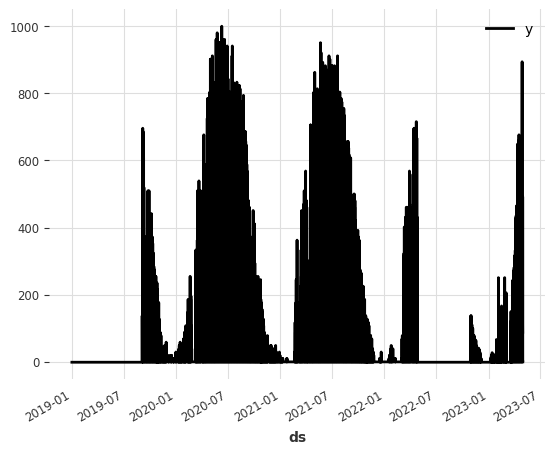

In [10]:
train_series[2].univariate_component("y").plot()

estimated_diff_hours
absolute_humidity_2m:gm3
air_density_2m:kgm3
dew_point_2m:K
diffuse_rad_1h:J
direct_rad_1h:J
effective_cloud_cover:p
fresh_snow_1h:cm
snow_depth:cm
sun_elevation:d
sun_azimuth:d
t_1000hPa:K
visibility:m
wind_speed_10m:ms
is_dew
is_rime
y_is_nan
exog_is_nan
sin_sun_elevation
global_rad_1h:J


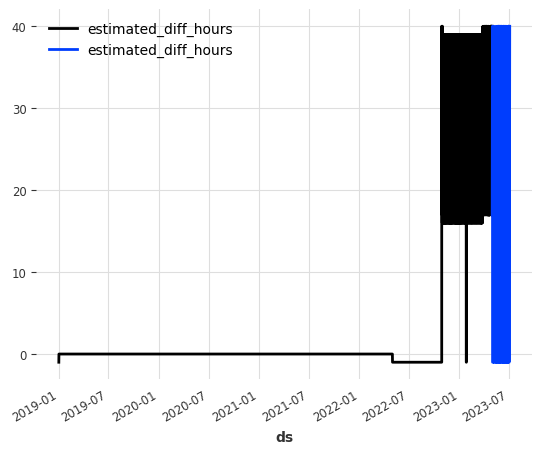

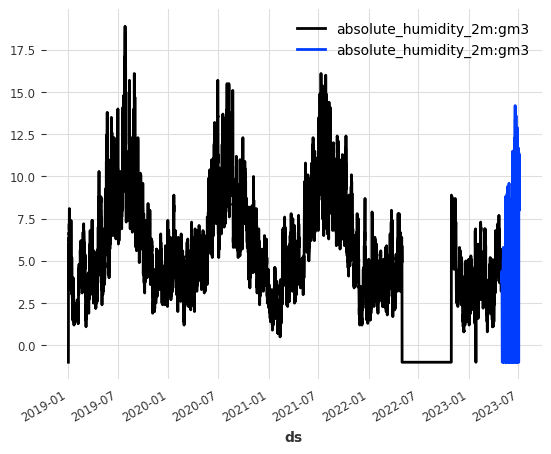

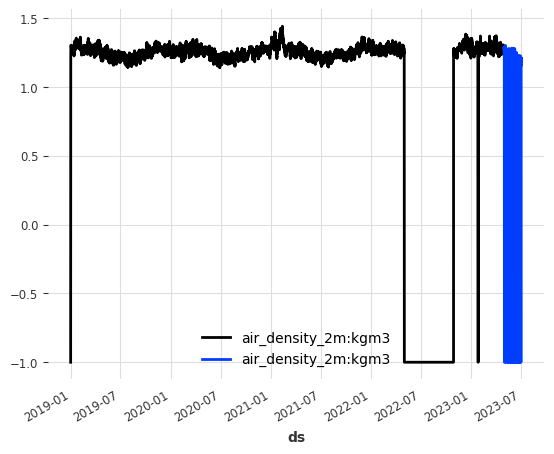

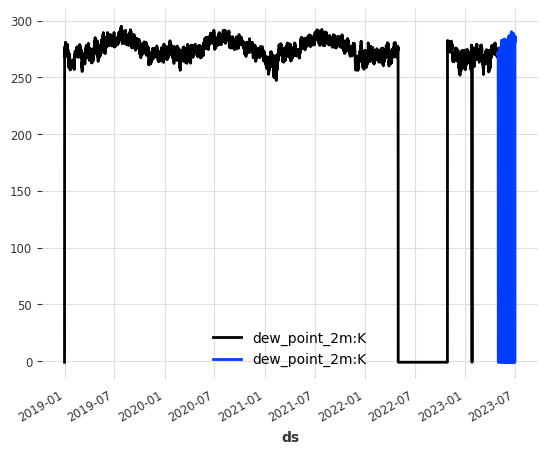

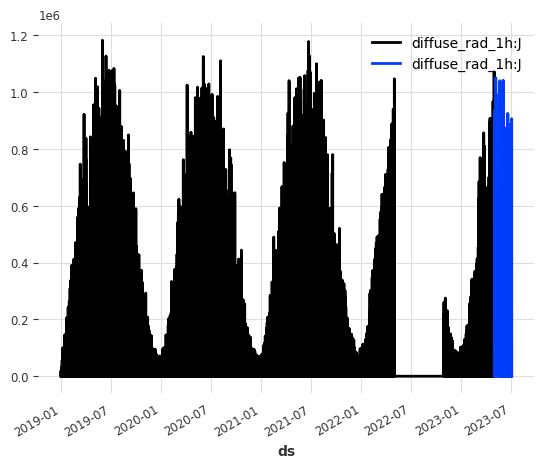

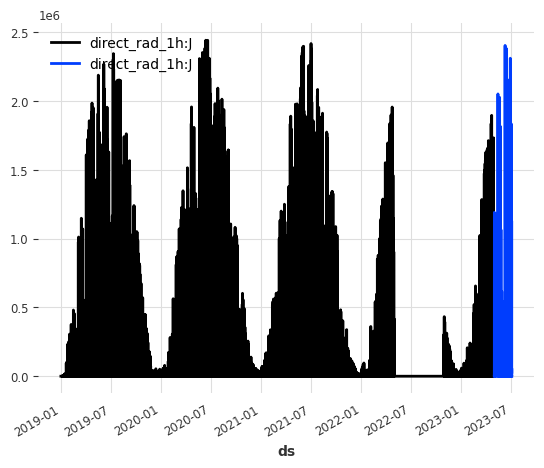

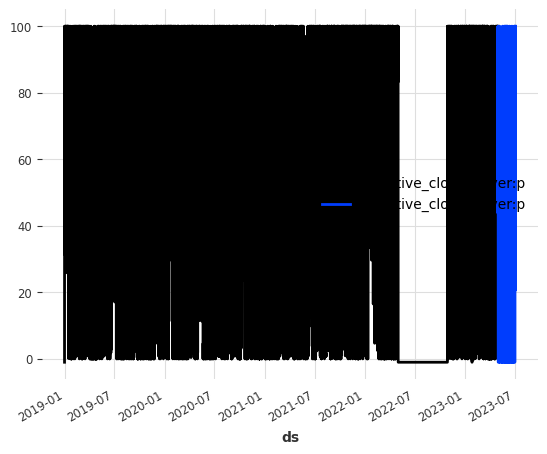

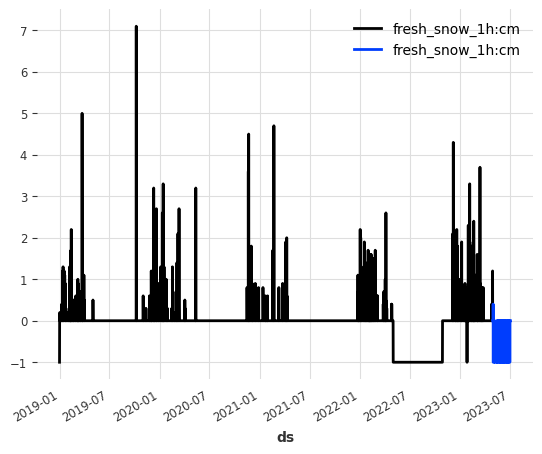

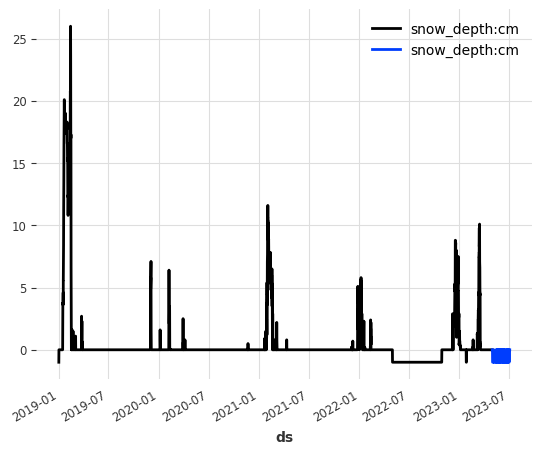

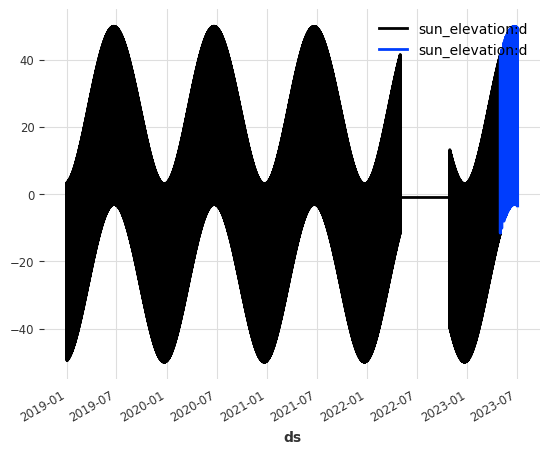

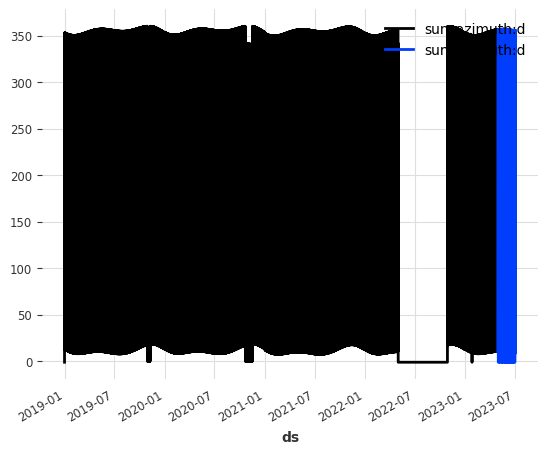

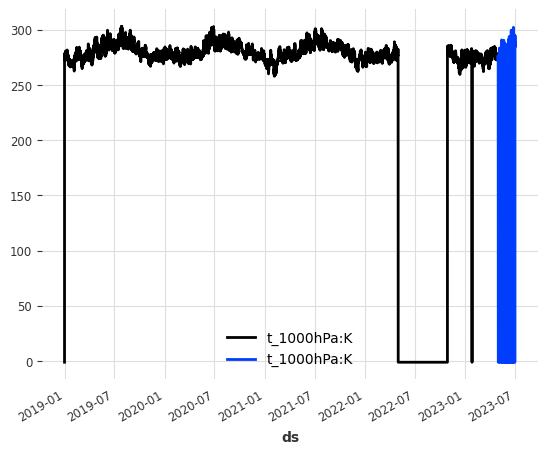

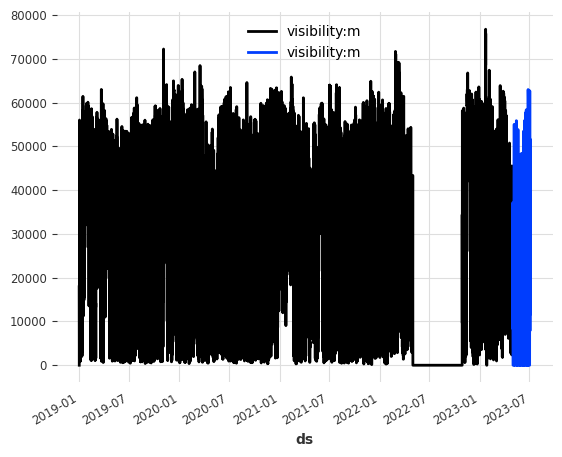

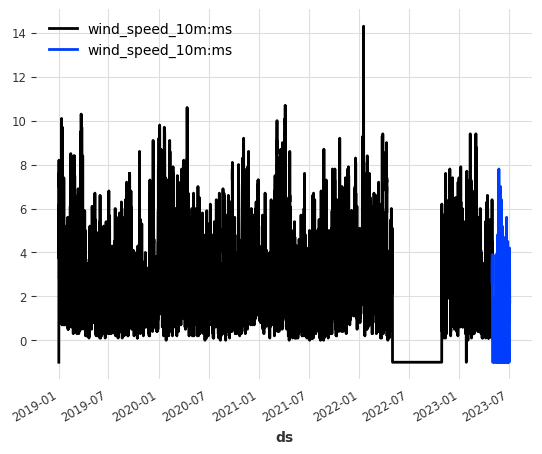

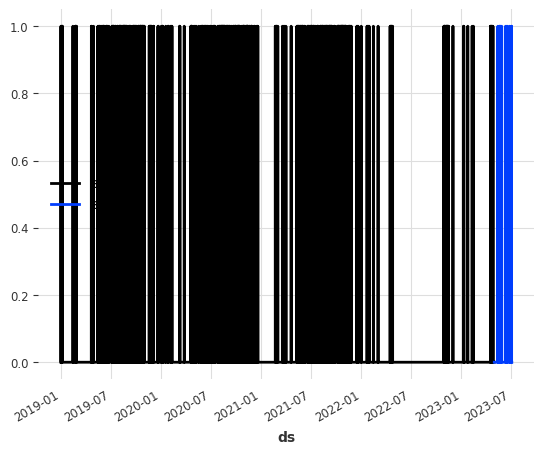

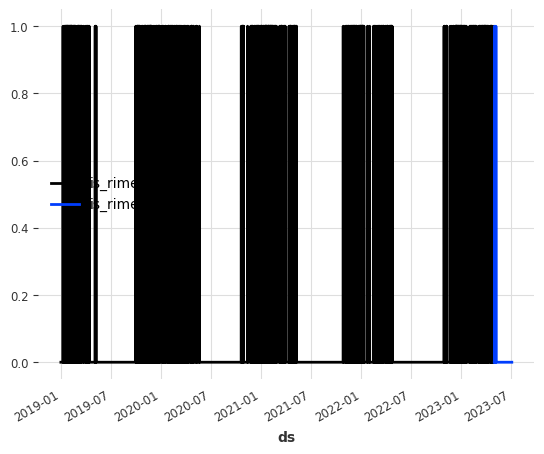

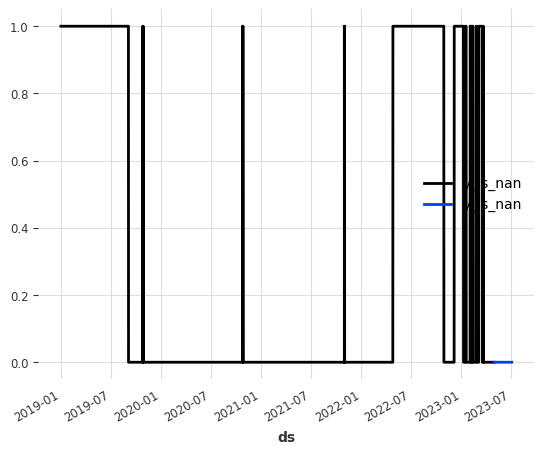

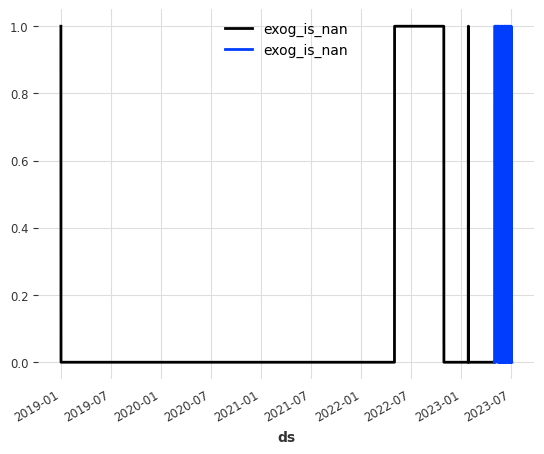

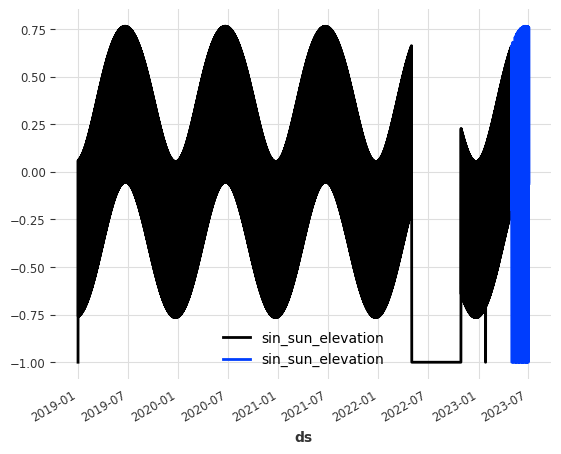

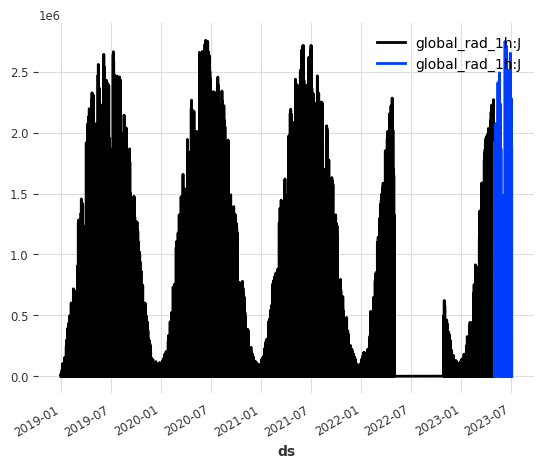

In [1180]:
i=2
from darts.utils.statistics import plot_hist
for exog in EXOGENOUS:
    print(exog)
    train_series[i].univariate_component(exog).plot(new_plot=True)
    covariate_future[i].univariate_component(exog).plot()


estimated_diff_hours
absolute_humidity_2m:gm3
air_density_2m:kgm3
dew_point_2m:K
diffuse_rad_1h:J
direct_rad_1h:J
effective_cloud_cover:p
fresh_snow_1h:cm
snow_depth:cm
sun_elevation:d
sun_azimuth:d
t_1000hPa:K
visibility:m
wind_speed_10m:ms
is_dew
is_rime
y_is_nan
exog_is_nan
sin_sun_elevation
global_rad_1h:J


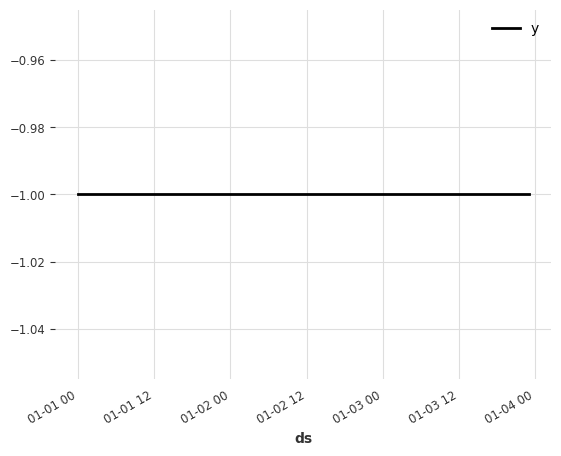

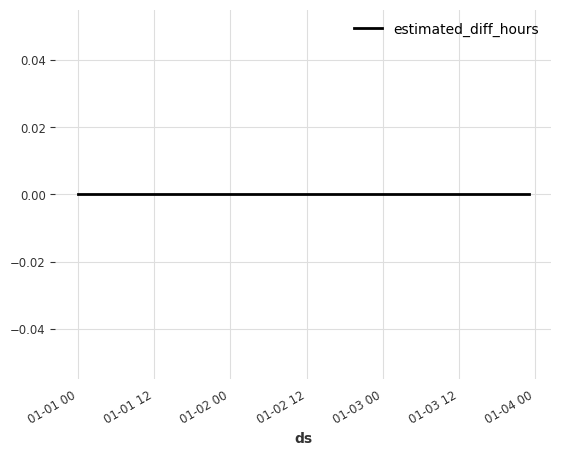

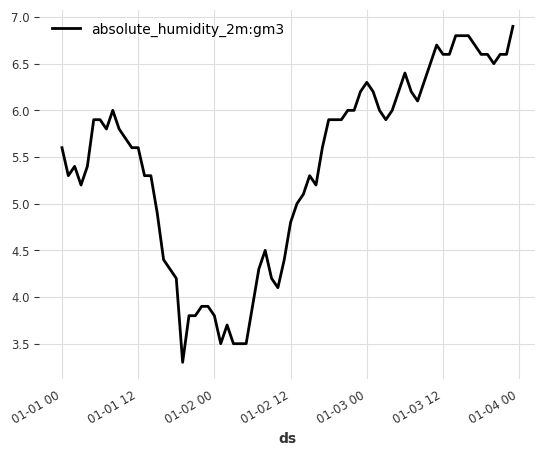

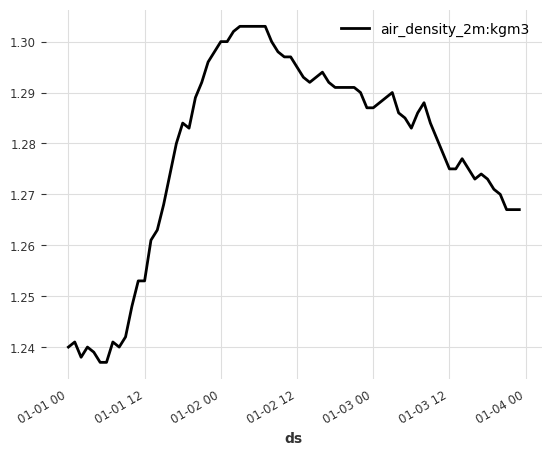

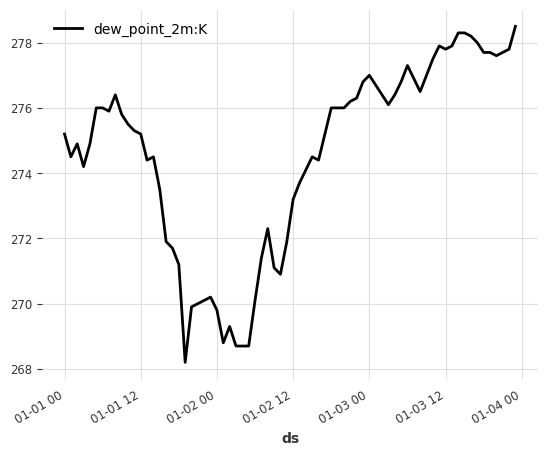

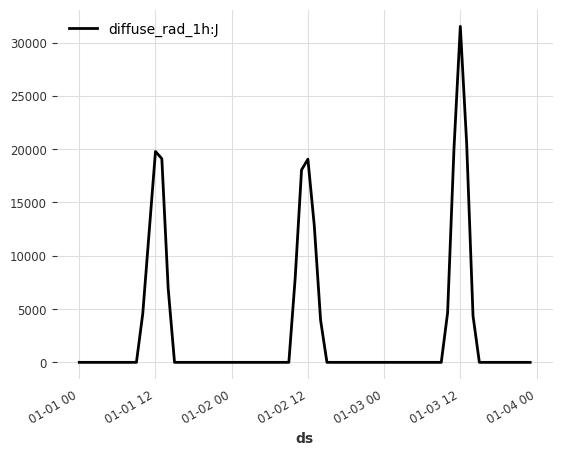

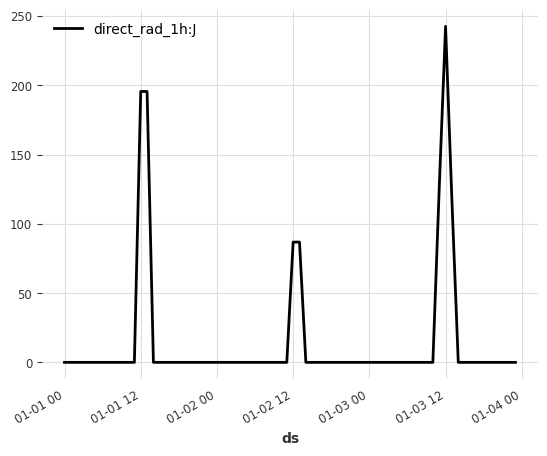

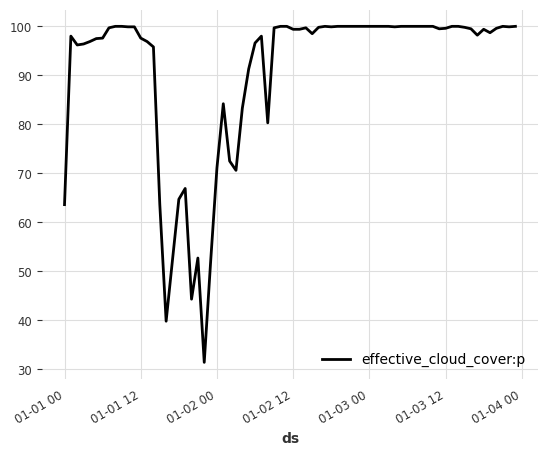

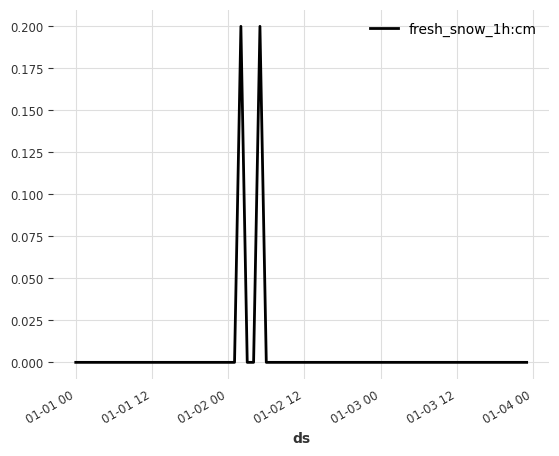

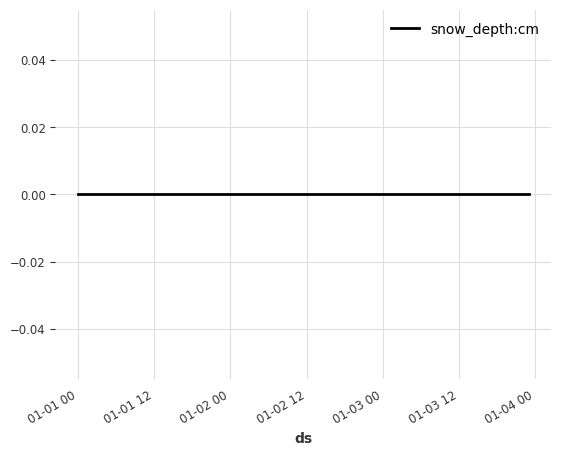

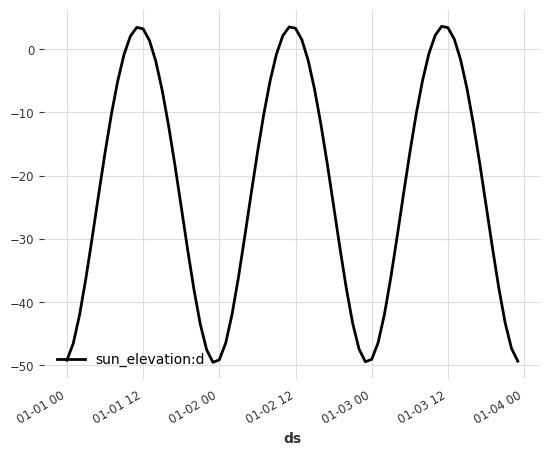

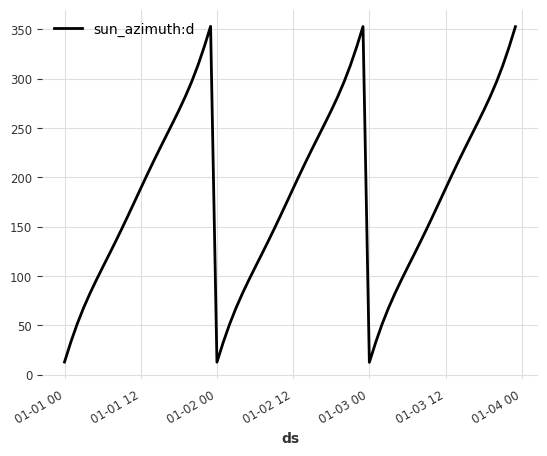

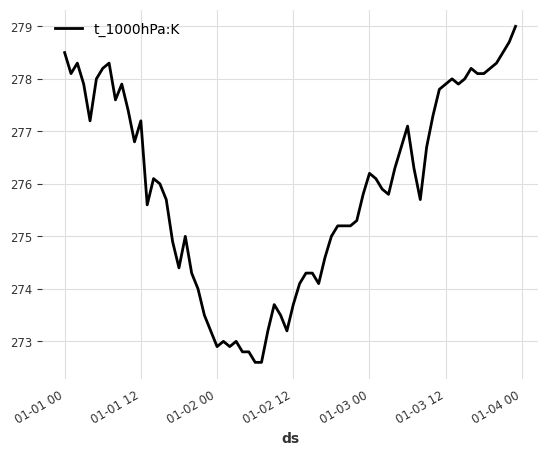

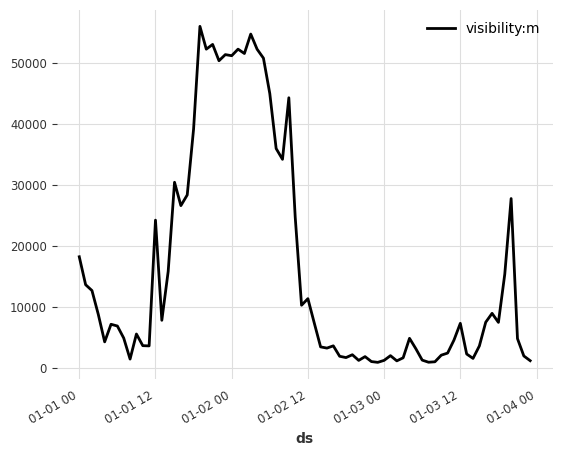

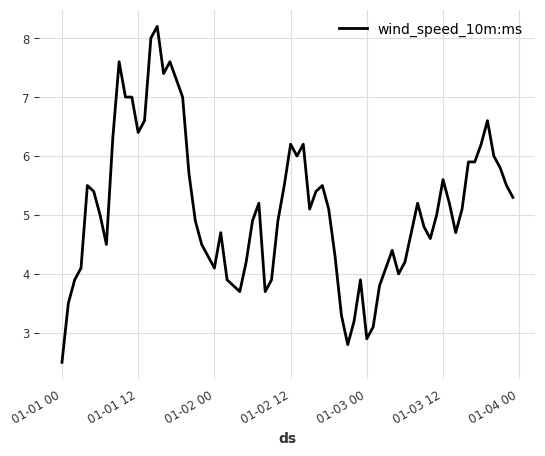

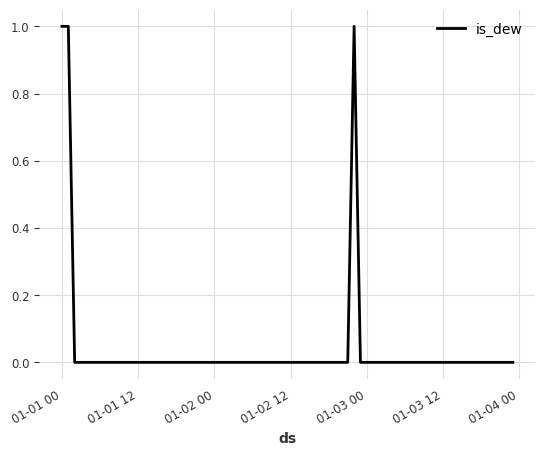

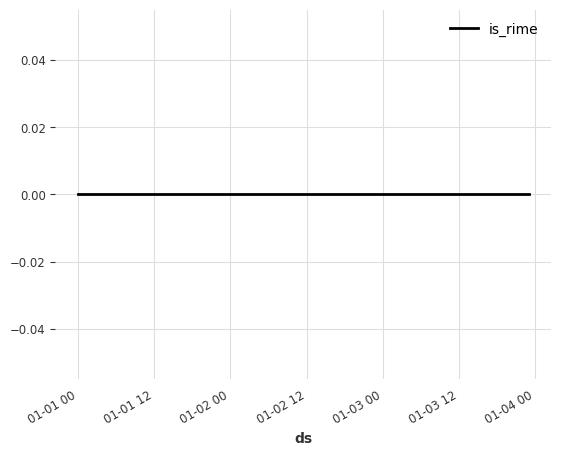

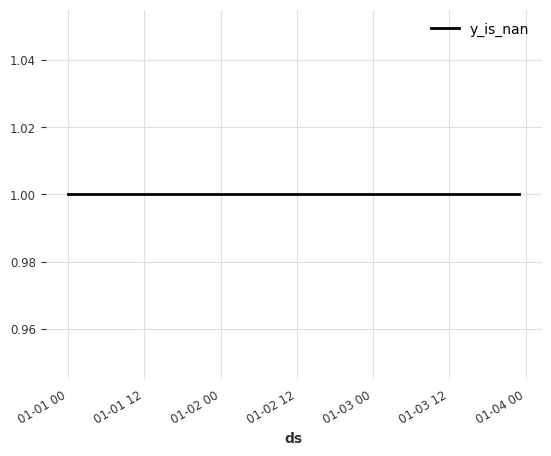

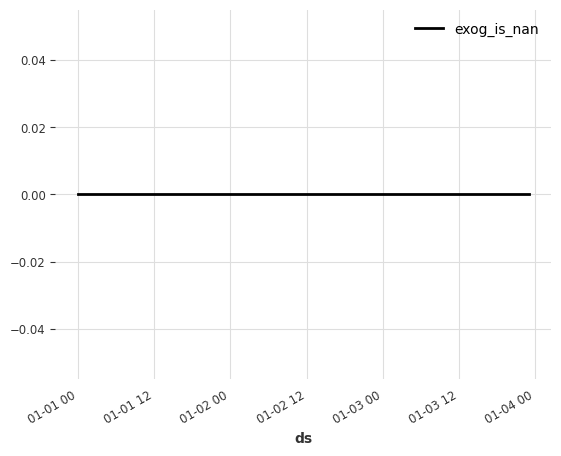

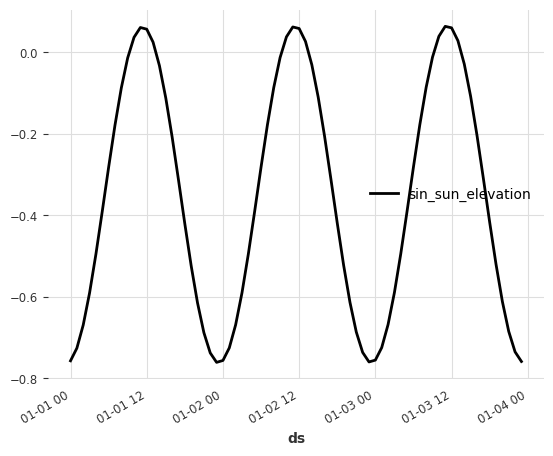

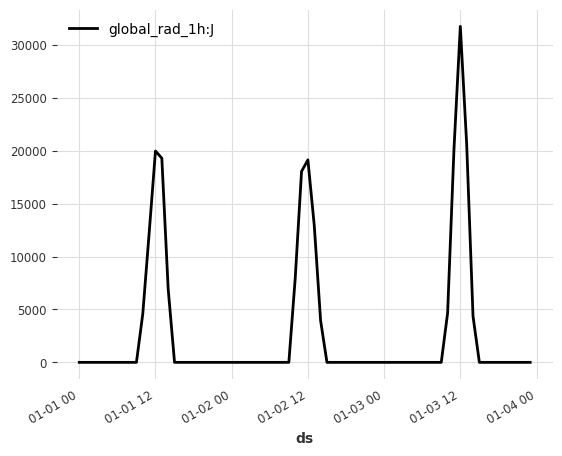

In [1181]:
# now look at just the first 48 hours
delta = 72
end_time = train_series[i].start_time() + pd.Timedelta(hours=delta)
train_series[i].univariate_component("y").slice_n_points_before(end_time, delta).plot()
for exog in EXOGENOUS:
    print(exog)
    train_series[i].univariate_component(exog).slice_n_points_before(end_time, delta).plot(new_plot=True)
    #covariate_future[i].univariate_component(exog).slice_n_points_before(end_time, delta).plot()

In [1182]:
# workaround dropna
def create_multiple_non_nan_series(series, minimum_length=24*7):
    df = series.pd_dataframe()
    df.dropna(inplace=True)
    new_timeseries = TimeSeries.from_dataframe(df=df, freq="H", fill_missing_dates=False, fillna_value=None, value_cols=None)
    
    # Get the gaps DataFrame
    gaps_df = new_timeseries.gaps()
    
    # Create a list to store the resulting TimeSeries slices
    series_list = []
    
    # Initialize the start date for the first slice
    slice_start = new_timeseries.start_time()
    
    # Iterate through the rows in the gaps DataFrame
    for index, row in gaps_df.iterrows():
        gap_start, gap_end = row['gap_start'], row['gap_end']
        
        # Create a new slice from slice_start to gap_start - 1 freq
        slice_end = gap_start - pd.Timedelta(hours=1)
        sliced_series = new_timeseries.slice(slice_start, slice_end)
        #print(sliced_series.gaps(), "HEIEH",sliced_series.start_time(), sliced_series.end_time())
        #print(sliced_series.head(1))
        
        # Append the slice to the list
        if len(sliced_series) >= minimum_length:
            series_list.append(sliced_series)
        
        # Update slice_start for the next iteration
        slice_start = gap_end + pd.Timedelta(hours=1)
    
    # Handle the slice after the last gap
    slice_end = new_timeseries.end_time()
    sliced_series = new_timeseries.slice(slice_start, slice_end)
    #print(sliced_series.gaps(), "HEIEH",sliced_series.start_time(), sliced_series.end_time())
    series_list.append(sliced_series)
    
    return series_list

In [1183]:
# seperate into y_train and covariate_train
y_train = train_series[i].univariate_component("y")
y_trains = create_multiple_non_nan_series(y_train, minimum_length=24*7)
covariate_train = train_series[i].drop_columns(["y"])
covariate_trains = [covariate_train.slice_intersect(yt) for yt in y_trains]
#covariate_trains[1].head(1)
covariate_train

<TimeSeries (DataArray) (ds: 37945, component: 20, sample: 1)>
array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        ...,
        [ 1.        ],
        [-1.        ],
        [-1.        ]],

       [[ 0.        ],
        [ 5.5999999 ],
        [ 1.24000001],
        ...,
        [ 0.        ],
        [-0.75674412],
        [ 0.        ]],

       [[ 0.        ],
        [ 5.30000019],
        [ 1.24100006],
        ...,
...
        ...,
        [ 0.        ],
        [-0.1354389 ],
        [ 0.        ]],

       [[38.99861111],
        [ 4.4000001 ],
        [ 1.27900004],
        ...,
        [ 0.        ],
        [-0.18508349],
        [ 0.        ]],

       [[39.99861111],
        [ 4.4000001 ],
        [ 1.27999997],
        ...,
        [ 0.        ],
        [-0.20659697],
        [ 0.        ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2018-12-31T23:00:00 ... 2023-04-30T23:00:00
  * component  (component) object 'estimated_diff_hours' ... 'global_rad_1h:J'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  location\nglobal_components       2.0
    hierarchy:          None

No gaps


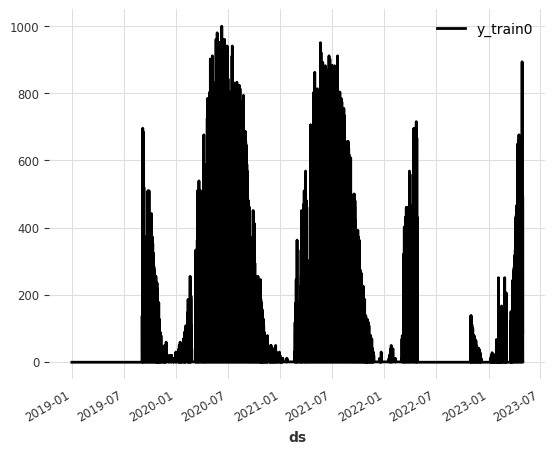

In [1184]:
for j in range(len(y_trains)):
    print("No gaps" if y_trains[j].gaps().shape[0]==0 else "Has Gaps")
    #print(y_trains[j].start_time(), y_trains[j].end_time())
    # plot
    y_trains[j].plot(label=f"y_train{j}")

In [1185]:
# covariate_trains[4].pd_dataframe().head(1)

# Do it for all 3 locations

Shape of y_train before dropping gaps: (34274, 1)
Shape of y_train after dropping gaps: (34274, 1)
Shape of y_train before dropping gaps: (37945, 1)
Shape of y_train after dropping gaps: (37945, 1)
Shape of y_train before dropping gaps: (37945, 1)
Shape of y_train after dropping gaps: (37945, 1)


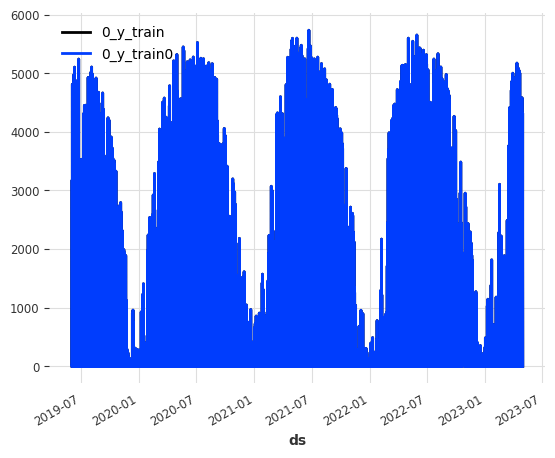

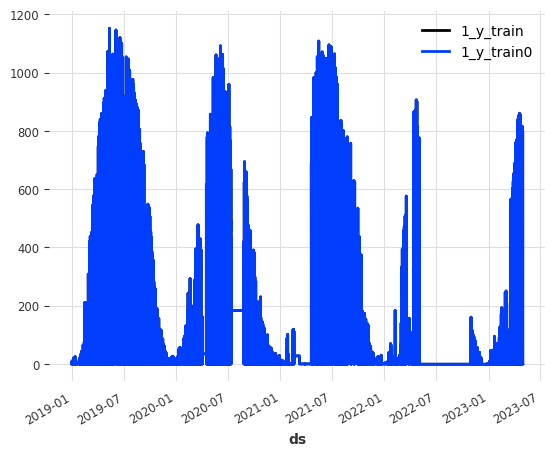

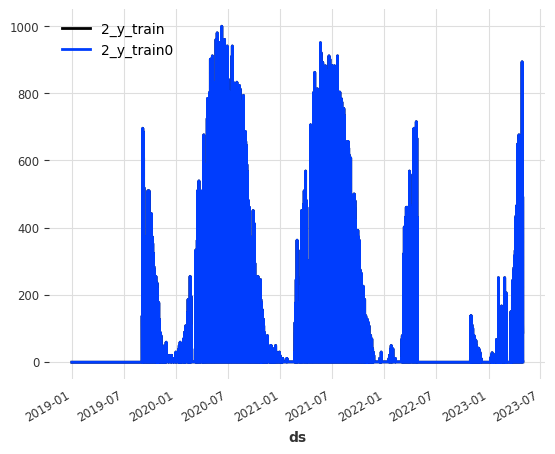

In [1223]:
# from sklearn.preprocessing import MinMaxScaler
# from darts.dataprocessing.transformers import Scaler, BoxCox

# store the data in list
y_trains_list = []
covariate_trains_list = []


mode = "longest_series_without_gap" # "many_series_without_gap" "longest_series_without_gap"
#mode = "many_series_without_gap" # "many_series_without_gap" "longest_series_without_gap"
one_model_for_all = False
is_single_gbtree_model=False
use_validation_set = True
train_val_split = pd.Timestamp("2023-02-01 00:00:00")
use_gridsearch = False
forecast_horizon = len(covariate_future[0])
stride = forecast_horizon
start=0.5
model_name="ensemble003"
use_naive_ensemble=True
models_to_train = [
    ["xgb", "catboost"],
    ["catboost", "rforest"],
    ["xgb", "catboost"],
    ]

use_all_even_with_missing = False # doesnt work

predict_multivariate = False # if to predict only y, or all exogenous variables as well

for i in range(len(train_series)):
    if mode == "many_series_without_gap":
        # seperate into y_train and covariate_train
        y_train = train_series[i].univariate_component("y") # use these two lines if you want to use many different series without gap
        y_trains = create_multiple_non_nan_series(y_train)

    elif mode == "longest_series_without_gap":
        # get longest series without gap
        print("Shape of y_train before dropping gaps:", train_series[i].univariate_component("y").pd_dataframe().shape)
        print("Shape of y_train after dropping gaps:", train_series[i].univariate_component("y").longest_contiguous_slice().pd_dataframe().shape)
        y_trains = [train_series[i].univariate_component("y").longest_contiguous_slice()]

    covariate_train = train_series[i].drop_columns(["y"])
    covariate_trains = [covariate_train.slice_intersect(yt) for yt in y_trains]

    if use_all_even_with_missing:
        y_trains=[train_series[i].univariate_component("y")]
        covariate_trains=[train_series[i].drop_columns(["y"])]
        



    y_trains_list.append(y_trains[0] if mode == "longest_series_without_gap" else y_trains)
    covariate_trains_list.append(covariate_trains[0] if mode == "longest_series_without_gap" else covariate_trains)


    train_series[i].univariate_component("y").plot(label=f"{i}_y_train", new_plot=True)


    
    for j in range(len(y_trains)):
        y_trains[j].plot(label=f"{i}_y_train{j}", new_plot=False)


In [1224]:
from darts.models import (
    XGBModel,
    RegressionEnsembleModel,
    LightGBMModel,
    NaiveEnsembleModel,
    CatBoostModel,
    RandomForest,
    NBEATSModel,
    TiDEModel,
)
from darts.dataprocessing.transformers import Scaler, BoxCox
from darts.metrics import mae
# get the torch mae equivalent
from darts.utils.losses import MAELoss

add_encoders = {
    #'cyclic': {'future': ['hour', 'month']},
    "datetime_attribute": {"future": ["hour", "month"]},
    # 'position': {'past': ['relative'], 'future': ['relative']},
    # 'custom': {'past': [lambda idx: (idx.year - 1950) / 50]},
    # "transformer": Scaler(),
}

# best for A
# Best parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.03, 'objective': 'reg:absoluteerror', 'booster': 'gbtree', 'random_state': 42, 'lags': [-2400], 'lags_future_covariates': [0], 'add_encoders': {'datetime_attribute': {'future': ['hour', 'month']}, 'transformer': Scaler}}

# best for B
# Best parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1, 'objective': 'reg:absoluteerror', 'booster': 'gbtree', 'random_state': 42, 'lags': [-2400], 'lags_future_covariates': [0], 'add_encoders': {'datetime_attribute': {'future': ['hour', 'month']}, 'transformer': Scaler}}

# best for C
# Best parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.03, 'objective': 'reg:absoluteerror', 'booster': 'gbtree', 'random_state': 42, 'lags': [-2400], 'lags_future_covariates': [0], 'add_encoders': {'datetime_attribute': {'future': ['hour', 'month']}, 'transformer': Scaler}}


parameters_dict = {
    "XGBModel": {
        "n_estimators": [500],
        "max_depth": [6],
        "learning_rate": [0.03],
        "objective": ["reg:absoluteerror"],
        "booster": ["gbtree"],
        "random_state": [42],
        "lags": [[-24 * 365]],
        "lags_future_covariates": [[0]],
        "add_encoders": [add_encoders],
    },
    "LightGBMModel": {
        "n_estimators": [700, 300, 500, 1000, 1500],
        "max_depth": [6, 5, 7, 8, 13], 
        "learning_rate": [0.01, 0.1, 0.03],
        "objective": ["regression"],
        "random_state": [42],
        "lags": [[-24 * 365]],
        "lags_future_covariates": [[0]],
        "add_encoders": [add_encoders],
        "verbose": [-1],  # -1 for no output
        # "use_missing": [False],
        # "zero_as_missing": [True],
    },
    "CatBoostModel": {
        "n_estimators": [500, 300, 700, 1000],
        "max_depth": [6],#, 5, 7, 8, 13],
        "learning_rate": [0.03, 0.01],
        "objective": ["MAE"],
        "random_state": [42],
        "lags": [[-24 * 365]],
        "lags_future_covariates": [[0]],
        "add_encoders": [add_encoders],
        # "nan_mode": ["Min"],
    },
    "RandomForest": {
        #"n_estimators": [400],
        #"max_depth": [None],
        # "min_samples_split": [2, 5],
        # "min_samples_leaf": [1, 4],
        # "criterion": ["absolute_error"],
        # # "random_state": [42],
        "max_features": ["sqrt"],#, None],
        # #"oob_score": [True, False],
        "bootstrap": [True],
        "lags": [[-24 * 365]],
        "lags_future_covariates": [[0]],
        "add_encoders": [add_encoders],
    },
}

locations_override = {
    "XGBModel": [{}, {"learning_rate": 0.03}, {}],
    "LightGBMModel": [{}, {"n_estimators": 300, "learning_rate": 0.03}, {"max_depth": 13}],
    "CatBoostModel": [{}, {}, {}],
    "RandomForest": [{}, {}, {}],
}


def create_model(location, name):
    if name == "xgb":
        return XGBModel(**{**{k: v[0] for k, v in parameters_dict["XGBModel"].items()}, **locations_override["XGBModel"][location]})

    elif name == "lgbm":
        return LightGBMModel(**{**{k: v[0] for k, v in parameters_dict["LightGBMModel"].items()}, **locations_override["LightGBMModel"][location]})

    elif name == "catboost":
        return CatBoostModel(**{**{k: v[0] for k, v in parameters_dict["CatBoostModel"].items()}, **locations_override["CatBoostModel"][location]})
    
    elif name == "rforest":
        return RandomForest(**{**{k: v[0] for k, v in parameters_dict["RandomForest"].items()}, **locations_override["RandomForest"][location]})

    elif name == "tide":
        tide = TiDEModel(input_chunk_length=1, output_chunk_length=24, add_encoders=add_encoders, pl_trainer_kwargs={"accelerator": "cpu"}, loss_fn=MAELoss)
        return tide

def create_ensemble_model(models):
    # assumes already trained models

    if use_naive_ensemble:
        return NaiveEnsembleModel(
            forecasting_models=models,
            train_forecasting_models=False,
        )

    return RegressionEnsembleModel(
        forecasting_models=models,
        regression_train_n_points=int(len(y_trains_list[0])/20),
        train_forecasting_models=False,
        #train_using_historical_forecasts=True,
    )


def backtest(model, y, cov, start):
    return model.backtest(
        series=y,
        future_covariates=cov,
        start=start,
        forecast_horizon=forecast_horizon,
        stride=stride,
        retrain=False,
        metric=mae,
    )

def mae_last_half_of_train(model, y_train, cov):
    s = int(len(y_train)/2)
    backtest = model.predict(
        s,
        series=y_train.head(len(y_train)-s),   
        future_covariates=cov
    )
    return mae(y_train.tail(s), backtest)

models = []
validation_mae = []






if mode == "longest_series_without_gap" and one_model_for_all:
    # create validation and train set
    models_trained = []
    for model_to_train in models_to_train[0]:
        model = create_model(location=0, name=model_to_train)
        if use_validation_set:
            target_trains, target_vals, cov_trains, cov_vals = [], [], [], []
            for i in range(len(y_trains_list)):
                target_train, target_val = y_trains_list[i].split_before(train_val_split)
                cov_train, cov_val = covariate_trains_list[i].split_before(train_val_split)
                target_trains.append(target_train)
                target_vals.append(target_val)
                cov_trains.append(cov_train)
                cov_vals.append(cov_val)

            model.fit(series=target_trains, future_covariates=cov_trains)
            for i in range(len(y_trains_list)):
                pred_val = model.predict(
                    len(target_vals[i]),
                    series=target_trains[i],
                    future_covariates=covariate_trains_list[i],
                )
                print("Validation MAE:", mae(target_vals[i], pred_val))

                target_vals[i].plot(label="Target", new_plot=True)
                pred_val.plot(label="Predictions")
                
                print("Backtest mean MAE:", mae_last_half_of_train(model, target_trains[i], covariate_trains_list[i]))

        else:
            model.fit(series=y_trains_list, future_covariates=covariate_trains_list)

            for i in range(len(backtests)):
                print("Backtest mean MAE:", mae_last_half_of_train(model, y_trains_list[i], covariate_trains_list[i]))

        models_trained.append(model)    

    if len(models_trained) == 1:
        models = [model, model, model]
    else:
        # create ensmble
        ensemble_model = create_ensemble_model(models_trained)
        ensemble_model.fit(series=y_trains_list, future_covariates=covariate_trains_list)
        for i in range(len(y_trains_list)):
            print("Ensemble backtest mean MAE:", mae_last_half_of_train(ensemble_model, y_trains_list[i], covariate_trains_list[i]))

        models = [ensemble_model, ensemble_model, ensemble_model]



elif mode == "longest_series_without_gap" and not one_model_for_all:
    models = []
    for i in range(len(y_trains_list)):
        print(i)
        
        models_trained = []
        for model_to_train in models_to_train[i]:
            model = create_model(location=i, name=model_to_train)

            m = type(model)
            print("Model:", m, m.__name__)


            if use_gridsearch:
                model, best_parameters, best_score = m.gridsearch(
                        parameters=parameters_dict[m.__name__],
                        series=y_trains_list[i],
                        future_covariates=covariate_trains_list[i],
                        # val_series=target_val,
                        show_warnings=True,
                        verbose=True,
                        metric=mae,
                        forecast_horizon=forecast_horizon,
                        stride=stride,
                    )
                print("BEST SCORE is:", best_score)
                print("Best parameters:", best_parameters)
                # print("MODEL:", model)
                print("Now fitting model with best parameters")
                model.fit(
                    series=y_trains_list[i], future_covariates=covariate_trains_list[i]
                )
                print("Backtest mean MAE:", mae_last_half_of_train(model, y_trains_list[i], covariate_trains_list[i]))

            if not use_gridsearch:
                if use_validation_set:
                    target_train, target_val = y_trains_list[i].split_before(train_val_split)
                    cov_train, cov_val = covariate_trains_list[i].split_before(train_val_split)
                    # print(cov_train.pd_dataframe().shape, target_train.pd_dataframe().shape)
                    # print(cov_val.pd_dataframe().shape, target_val.pd_dataframe().shape)
                    # print(
                    #     "Start and end dates of train set:",
                    #     target_train.start_time(),
                    #     target_train.end_time(),
                    # )
                    # print(
                    #     "Start and end dates of validation set:",
                    #     target_val.start_time(),
                    #     target_val.end_time(),
                    # )

                    if predict_multivariate:
                        model.fit(
                            series=train_series[i].slice_intersect(target_train),
                            future_covariates=cov_train,
                        )
                        all_predictions = model.predict(
                            len(target_val),
                            future_covariates=cov_train.concatenate(cov_val),
                            series=train_series[i].slice_intersect(target_train),
                        )
                        pred_val = all_predictions.univariate_component("y")
                    else:
                        model.fit(series=target_train, future_covariates=cov_train)
                        pred_val = model.predict(
                            len(target_val),
                            future_covariates=covariate_trains_list[i],
                            series=target_train,
                        )

                    print("Validation MAE:", mae(target_val, pred_val))

                    # target_val.plot(label="Target", new_plot=True)
                    # pred_val.plot(label=f"{model_to_train} location {i}")

                    print("Backtest mean MAE:", mae_last_half_of_train(model, target_train, cov_train))
                else:
                    model.fit(
                        series=y_trains_list[i], future_covariates=covariate_trains_list[i]
                    )

                    print("Backtest mean MAE:", mae_last_half_of_train(model, y_trains_list[i], covariate_trains_list[i]))

            models_trained.append(model)

        if len(models_trained) == 1:
            models.append(models_trained[0])

        else:
            # create ensmble
            #ensemble_model = create_ensemble_model(models_trained)
            ensemble_model = create_ensemble_model(models_trained)
            if use_validation_set:
                ensemble_model.fit(series=target_train, future_covariates=cov_train)
                pred_val = ensemble_model.predict(
                    len(target_val),
                    future_covariates=covariate_trains_list[i],
                    series=target_train,
                )
                print("Ensemble validation set MAE:", mae(target_val, pred_val))
                # target_val.plot(label="Target", new_plot=True)
                # pred_val.plot(label=f"Predictions for location {i}, ensemble model")
                print("Ensemble backtest MAE:", mae_last_half_of_train(ensemble_model, target_train, cov_train))
                
            else:
                ensemble_model.fit(series=y_trains_list[i], future_covariates=covariate_trains_list[i])
                print("Ensemble backtest MAE:", mae_last_half_of_train(ensemble_model, y_trains_list[i], covariate_trains_list[i]))

            models.append(ensemble_model)

        


# elif mode == "many_series_without_gap" and one_model_for_all:
#     model = create_model()
#     for i in range(3):
#         y_trains = y_trains_list[i]
#         for j in range(len(y_trains)):
#             print(i, j)
#             model.fit(y_trains[j], future_covariates=covariate_trains[j], verbose=True)

# elif mode == "many_series_without_gap" and not one_model_for_all:
#     models = []
#     for i in range(3):
#         y_trains = y_trains_list[i]
#         model = create_model()
#         for j in range(len(y_trains)):
#             print(i, j)
#             model.fit(y_trains[j], future_covariates=covariate_trains[j], verbose=True)

#         models.append(model)

0
Model: <class 'darts.models.forecasting.xgboost.XGBModel'> XGBModel
Validation MAE: 195.95260046906316
Backtest mean MAE: 182.93240268939144
Model: <class 'darts.models.forecasting.catboost_model.CatBoostModel'> CatBoostModel
Validation MAE: 204.08920360646974
Backtest mean MAE: 205.52065014688205
Ensemble validation set MAE: 198.30355604303037
Ensemble backtest MAE: 192.61519541369032
1
Model: <class 'darts.models.forecasting.catboost_model.CatBoostModel'> CatBoostModel
Validation MAE: 43.720892376517305
Backtest mean MAE: 25.884285539134584
Model: <class 'darts.models.forecasting.random_forest.RandomForest'> RandomForest
Validation MAE: 45.016834919693274
Backtest mean MAE: 9.62788714391279
Ensemble validation set MAE: 43.41489470001597
Ensemble backtest MAE: 17.527686054432028
2
Model: <class 'darts.models.forecasting.xgboost.XGBModel'> XGBModel
Validation MAE: 22.393901724770657
Backtest mean MAE: 12.92215954959796
Model: <class 'darts.models.forecasting.catboost_model.CatBoostMo

In [1225]:
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot feature importance
def plot_feature_importance(model, train_data, location):
    gain= model.get_booster().get_score(importance_type="gain")
    weight = model.get_booster().get_score(importance_type="weight")

    #plot_importance(model, title=f"Feature importance for {location} (weigth: number of times used)")

    feature_importance_gain = [(col, gain[f"f{i}"] if f"f{i}" in gain else 0) for i, col in enumerate(train_data.columns)]
    feature_importance_gain = sorted(feature_importance_gain, key=lambda x: x[1], reverse=False)

    feature_importance_weight = [(col, weight[f"f{i}"] if f"f{i}" in weight else 0) for i, col in enumerate(train_data.columns)]
    feature_importance_weight = sorted(feature_importance_weight, key=lambda x: x[1], reverse=False)

    plt.figure(figsize=(10, 10))
    plt.barh([x[0] for x in feature_importance_gain], [x[1] for x in feature_importance_gain])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    #The gain type shows the average gain across all splits where feature was used.
    plt.title(f"Feature importance for {location} (average gain of splits)")
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.barh([x[0] for x in feature_importance_weight], [x[1] for x in feature_importance_weight])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    # The weight shows the number of times the feature is used to split data. This type of feature importance can favourize numerical and high cardinality features. Be careful!
    plt.title(f"Feature importance for {location} (weigth: number of times used)")
    plt.show()
    

# Existing function for correlation heatmap
def correlation_heatmap(train):
    correlations = train.pd_dataframe().corr()
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show()

if is_single_gbtree_model:
    # Loop to iterate over different models and training sets
    for idx, (model, covariate_trains) in enumerate(zip(models, covariate_trains_list)):
        plot_feature_importance(model.model, covariate_trains, f"Location {idx}")
        correlation_heatmap(covariate_trains)


In [1226]:
hfs_list = []
for i in range(len(models)):
    hfs = models[i].historical_forecasts(y_trains_list[i], future_covariates=covariate_trains_list[i].concatenate(covariate_future[i]), forecast_horizon=forecast_horizon, stride=stride, retrain=False, verbose=True, start=start, last_points_only=False, overlap_end=True)
    hfs_list.append(hfs)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Number of historical forecasts: 12
Number of historical forecasts: 13
Number of historical forecasts: 13


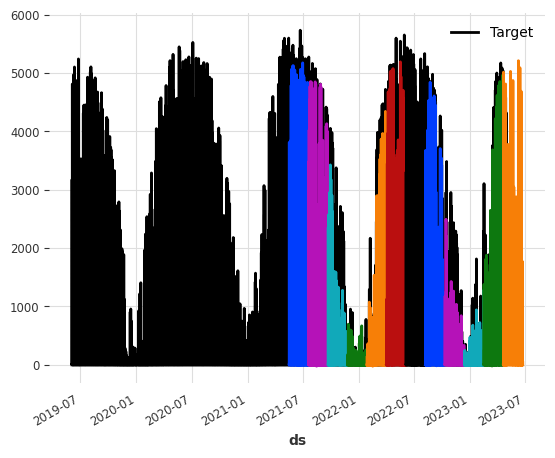

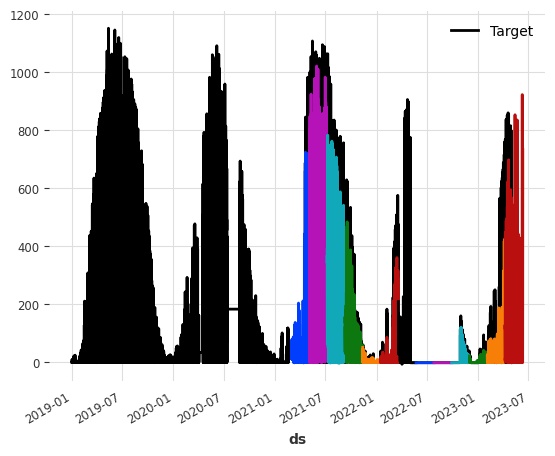

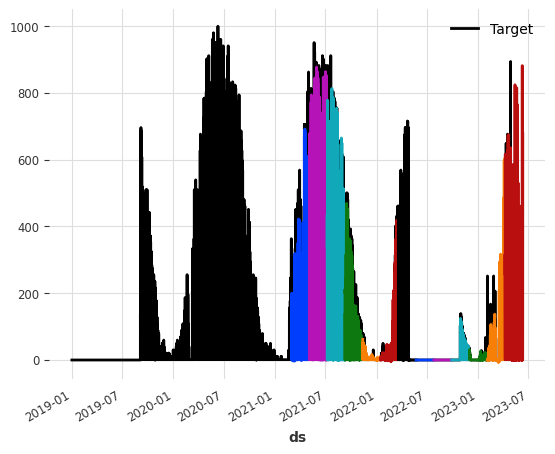

In [1227]:
for i in range(len(hfs_list)):
    y_trains_list[i].plot(label="Target", new_plot=True)
    print("Number of historical forecasts:", len(hfs_list[i]))
    for hf in hfs_list[i]:
        hf.plot(label=None)


In [1228]:
# # train 
# y = train_series[i].univariate_component("y")
# def dropna_workaround(series):
#     df = series.pd_dataframe()
#     df.dropna(inplace=True)
#     return TimeSeries.from_dataframe(df=df, freq="H", fill_missing_dates=False, fillna_value=None, value_cols=None)

# y = dropna_workaround(y)

# model = create_model()
# covariate_train = train_series[i].drop_columns(["y"]).slice_intersect(y)
# print(len(y), len(covariate_train), len(train_series[i]))
# model.fit(series=train, future_covariates=covariate_train)

In [1229]:
set(covariate_future[i].columns) - set(train_series[i].columns)

set()

SHape of covariate_future: (1536, 20)
2023-05-01 00:00:00 	End:  2023-07-03 23:00:00
SHape of train_series: (34274, 21) should be one more column than covariate_future because of y
2019-06-02 22:00:00 	End:  2023-04-30 23:00:00
SHape of covariate_future: (1536, 20)
2023-05-01 00:00:00 	End:  2023-07-03 23:00:00
SHape of train_series: (37945, 21) should be one more column than covariate_future because of y
2018-12-31 23:00:00 	End:  2023-04-30 23:00:00
SHape of covariate_future: (1536, 20)
2023-05-01 00:00:00 	End:  2023-07-03 23:00:00
SHape of train_series: (37945, 21) should be one more column than covariate_future because of y
2018-12-31 23:00:00 	End:  2023-04-30 23:00:00


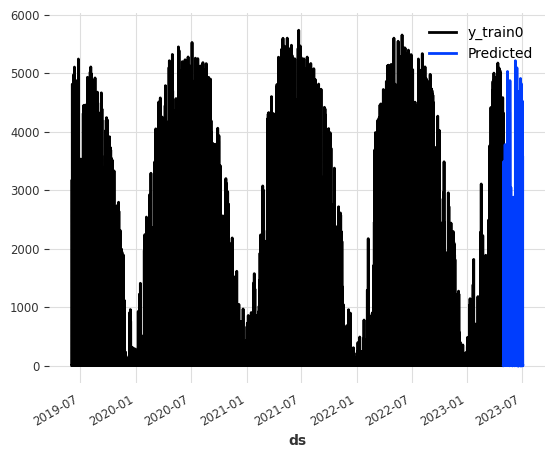

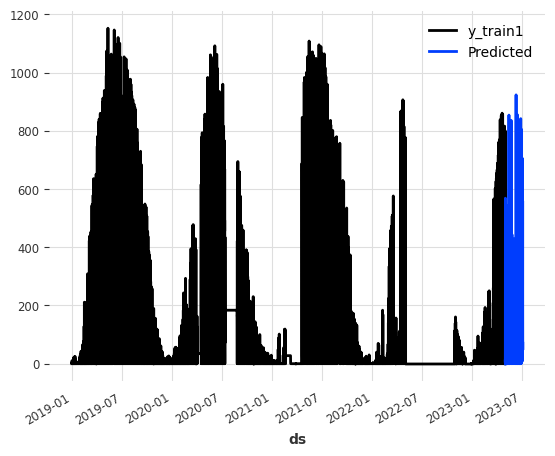

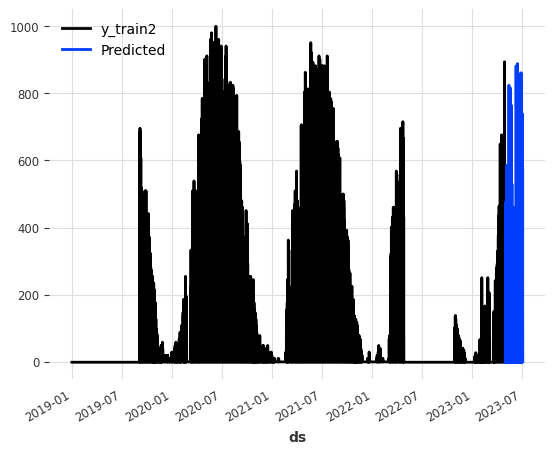

In [1230]:
predictions = []
all_predictions = []
for i in range(3):
    #yt = train_series[i].univariate_component("y")
    print(f"SHape of covariate_future: {covariate_future[i].pd_dataframe().shape}")
    print(covariate_future[i].start_time(), "\tEnd: ", covariate_future[i].end_time())
    print(f"SHape of train_series: {train_series[i].pd_dataframe().shape}", "should be one more column than covariate_future because of y")
    print(train_series[i].start_time(), "\tEnd: ", train_series[i].end_time())
    #print(covariate_trains_list[i].start_time(), "\tEnd: ", covariate_trains_list[i].end_time())


    if predict_multivariate:
        all_pred = models[i].predict(len(covariate_future[i]), series=train_series[i], future_covariates=covariate_trains_list[i].concatenate(covariate_future[i]))
        all_predictions.append(all_pred)
        y_pred = all_pred.univariate_component("y")
    else:
        y_pred = models[i].predict(len(covariate_future[i]), series=y_trains_list[i], future_covariates=covariate_trains_list[i].concatenate(covariate_future[i]))

    predictions.append(y_pred)

    # for j in range(len(y_trains)):
    #     y_trains[j].plot(label=f"y_train{j}")
    y_trains_list[i].plot(label=f"y_train{i}", new_plot=True)
    y_pred.plot(label='Predicted')

In [1231]:
for i in range(3):
    if predict_multivariate:
        for exog in EXOGENOUS:
            all_predictions[i].univariate_component(exog).plot(label=f"Predicted {exog}", new_plot=True)
            covariate_future[i].univariate_component(exog).plot(label=f"Actual {exog}")

# Submit

In [1232]:
# pull in test.csv and create submission.csv
test = pd.read_csv('test.csv', index_col=0)
# test has Id, Time, Location
# X_test has location_A, location_B, location_C
# we have to make sure that test has same dates as X_test, then predict y for each row in test, then save as submission.csv (using correct Id from test)

# convert index to datetime
test["id"] = test.index
test.set_index('time', inplace=True)
test.index = pd.to_datetime(test.index).astype('datetime64[ns]')
test

# split test into each location
print(test.groupby('location').count())


          prediction   id
location                 
A                720  720
B                720  720
C                720  720


A
component                     y
ds                             
2023-05-01 00:00:00    0.000001
2023-05-01 01:00:00   -0.005687
2023-05-01 02:00:00    0.242077
2023-05-01 03:00:00   35.415476
2023-05-01 04:00:00  258.029803
...                         ...
2023-07-03 19:00:00  127.171707
2023-07-03 20:00:00   43.156905
2023-07-03 21:00:00   -6.181147
2023-07-03 22:00:00   -0.086498
2023-07-03 23:00:00   -0.211067

[1536 rows x 1 columns]
B
component                    y
ds                            
2023-05-01 00:00:00   9.626049
2023-05-01 01:00:00   3.730669
2023-05-01 02:00:00   6.507932
2023-05-01 03:00:00   4.899353
2023-05-01 04:00:00  39.833765
...                        ...
2023-07-03 19:00:00  77.516650
2023-07-03 20:00:00  56.946812
2023-07-03 21:00:00  47.526920
2023-07-03 22:00:00  66.275355
2023-07-03 23:00:00  70.329301

[1536 rows x 1 columns]
C
component                    y
ds                            
2023-05-01 00:00:00   0.000024
2023-05-01 01:00:00   0.000038
2

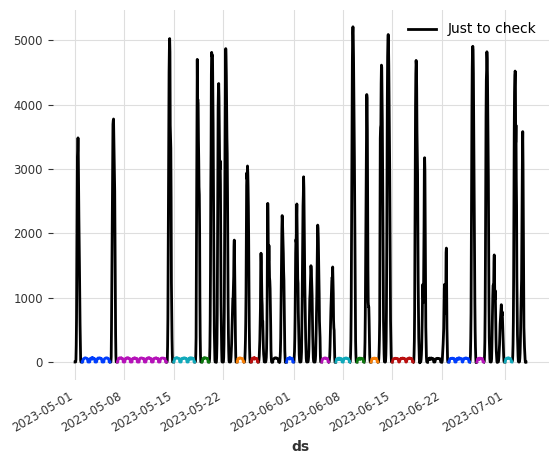

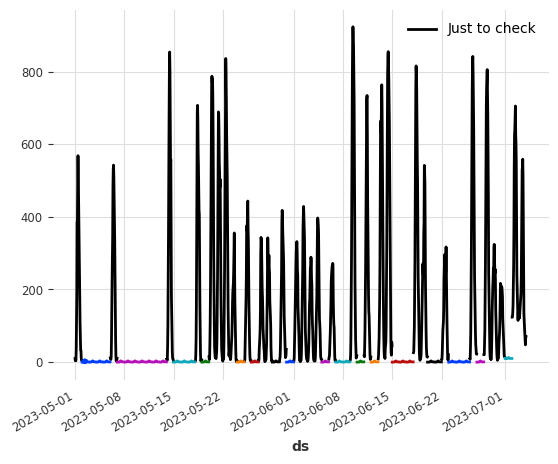

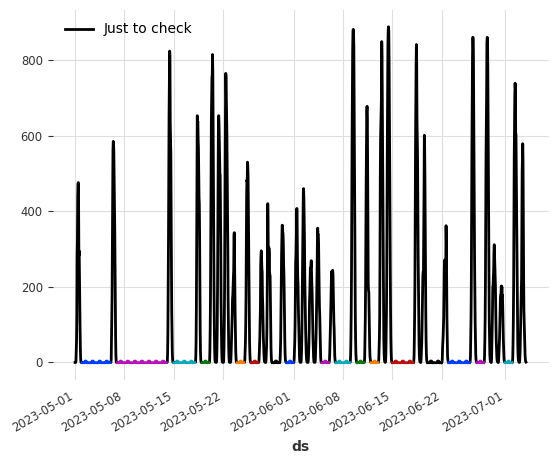

In [1233]:
import os
import pandas as pd

# Assuming X_test and model are already defined
# Assuming 'time' is also a datetime64[ns] column in X_test

location_mapping = {
    'A': 0,
    'B': 1,
    'C': 2
}

# Initialize an empty DataFrame to store the results
submission_df = pd.DataFrame()

# Group test by 'location' and iterate through each group
for location, group in test.groupby('location'):
    print(location)
    prediction = predictions[location_mapping[location]]
    y_pred = prediction.pd_dataframe()
    print(y_pred)
    
    # print(len(y_pred_submission), len(submission_series))
    # print(y_pred_submission.all_values().shape)
    #print(y_pred_submission.pd_dataframe()["y"])
    
    # Merge group and y_pred based on the index
    merged_df = pd.merge_asof(group.sort_index(), y_pred.sort_index(),
                              left_index=True, right_index=True)

    to_plot = TimeSeries.from_dataframe(df=merged_df[["y"]], freq="H", fill_missing_dates=False, fillna_value=None)
    to_plot.plot(label="Just to check", new_plot=True)

    all_gaps = to_plot.gaps()
    print_all_gaps = []
    for index, row in all_gaps.iterrows():
        gap_start, gap_end = row['gap_start'], row['gap_end']
        
        sliced_series = prediction.slice(gap_start, gap_end)
        print_all_gaps.append(sliced_series)
        sliced_series.plot(label=None)


    
    # Create a DataFrame with 'Id' and predicted values
    result_df = pd.DataFrame({
        'id': merged_df['id'],
        'prediction': merged_df['y']
    })
    
    # Append to submission DataFrame
    submission_df = pd.concat([submission_df, result_df])


# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv
# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}.csv'

# Save the submission
submission_df.to_csv(os.path.join('submissions', new_filename), index=False)


In [1237]:
def handle_not_serializable(obj):
    if hasattr(obj, '__dict__'):  # Check if obj has attributes
        return obj.__dict__
    else:
        raise TypeError(f"Object of type {type(obj).__name__} is not JSON serializable")

# get datetime
import datetime
import json
dt_now = datetime.datetime.now()

# Initialize an empty list to store all parameter dictionaries
all_params = []

for i in range(3):
    params = {**models[i].model_params}
    print(params)
    # pop "forecasting_models" from params
    models_params = params.pop("forecasting_models", None)
    print("models_params:", models_params)
    if models_params is not None:
        params["forecasting_models"] = [{"name": type(model).__name__, **model.model_params} for model in models_params]
    print(f"Best parameters for location {i}: ", params.items())
    
    # Append the current params dictionary to the all_params list
    all_params.append(params)

# Save the list of parameter dictionaries to a single JSON file
directory = f"models/{model_name}/submisison_{last_submission_number+1}"

# Create directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

with open(f"{directory}/best_params.json", "w") as outfile:
    json.dump(all_params, outfile, default=handle_not_serializable, indent=4)

# save model aswell
for i in range(3):
    models[i].save(f"{directory}/{type(models[i]).__name__}_{i}.pkl")


# save other params
other_params = {
    "EXOGENOUS": EXOGENOUS,
    "one_model_for_all": one_model_for_all,
    "is_single_gbtree_model": is_single_gbtree_model,
    "use_validation_set": use_validation_set,
    "train_val_split": train_val_split,
    "use_gridsearch": use_gridsearch,
    "forecast_horizon": forecast_horizon,
    "stride": stride,
    "start": start,
    "model_name": model_name,
    "use_naive_ensemble": use_naive_ensemble,
    "models_to_train": models_to_train,
    "fillna_value": fillna_value,
    "fillna_only_y": fillna_only_y,
    "use_all_even_with_missing": use_all_even_with_missing,
    "predict_multivariate": predict_multivariate,
}

with open(f"{directory}/variables.json", "w") as outfile:
    json.dump(other_params, outfile, default=handle_not_serializable, indent=4)
    

{'train_forecasting_models': False, 'show_warnings': True, 'forecasting_models': [XGBModel(lags=[-8760], lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=1, add_encoders={'datetime_attribute': {'future': ['hour', 'month']}}, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, n_estimators=500, max_depth=6, learning_rate=0.03, objective=reg:absoluteerror, booster=gbtree), CatBoostModel(lags=[-8760], lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=1, add_encoders={'datetime_attribute': {'future': ['hour', 'month']}}, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, n_estimators=500, max_depth=6, learning_rate=0.03, objective=MAE)]}
models_params: [XGBModel(lags=[-8760], lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=1, add_encoders={'datetime_attribute': {'future': ['hour', 'month']}}, likelihood=None, quantiles=None